# Chapter2. 자연어와 단어의 분산 표현
## 자연어 처리란
* 자연어 : 한국어와 영어 등 평소 사용하는 말  
* 자연어 처리(NLP) : 자연어를 처리하는 분야. 우리의 말을 컴퓨터에게 이해시키기 위한 기술(분야)
### 단어의 의미
* 단어 : 의미의 최소 단위
* 목표 : 자연어를 컴퓨터에게 이해시키려면, 그 단어의 의미를 이해시키는 것이 중요하다.
    * 시소러스 활용한 기법(이번 장)
    * 통계 기반 기법(이번 장)
    * 추론 기반 기법(word2vec)(다음 장)

## 시소러스
### WordNet
가장 유명한 시소러스
### 시소러스의 문제점
* 시대 변화에 대응하기 어렵다
* 사람을 쓰는 비용이 크다
* 단어의 미묘한 차이를 표현할 수 없다

## 통계 기반 기법
말뭉치(corpus) 이용한다.
### 파이썬으로 말뭉치 전처리하기
_'You say goodbye and I say hello.'_

In [2]:
text = 'You say goodbye and I say hello.'
text = text.lower()
text = text.replace('.',' .')
text

'you say goodbye and i say hello .'

In [3]:
words = text.split(' ')
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [4]:
word_to_id = {}
id_to_word = {}

In [5]:
for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [6]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [7]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [8]:
# 검색도 가능하다.
id_to_word[1]

'say'

In [9]:
word_to_id['hello']

5

In [10]:
# 파이썬 내포표기 활용해서 단어 ID 목록 변환 후 넘파이 배열로 변환
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

* 내포(comprehension) : 리스트, 딕셔너리 등의 반복문 처리를 간단화하는 기법

In [11]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [12]:
text = 'You say yes and I say no.'
corpus, word_to_id, id_to_word = preprocess(text)

In [13]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [14]:
word_to_id

{'you': 0, 'say': 1, 'yes': 2, 'and': 3, 'i': 4, 'no': 5, '.': 6}

In [15]:
id_to_word

{0: 'you', 1: 'say', 2: 'yes', 3: 'and', 4: 'i', 5: 'no', 6: '.'}

### 단어의 분산 표현
* 분산 표현(distributional representation): 간결하고 이치에 맞는 벡터 표현을 단어라는 영역에서 구축한다.

### 분포 가설
* 분포 가설(distributional hypothesis) : 단어의 의미가 주변 단어에 의해 형성된다.

### 동시발생 행렬
* 분포 가설에 기초해 단어를 벡터로 나타내는 방법.  
* 통계 기반 기법: 주변 단어의 개수를 세보는 방법

In [17]:
# 말뭉치 전처리하기
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess
text = 'You say yes and I say no. '
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)

[0 1 2 3 4 1 5 6 7]


In [18]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'yes', 3: 'and', 4: 'i', 5: 'no', 6: '.', 7: ''}


In [19]:
C = np.array([
    [0,1,0,0,0,0,0],
    [1,0,1,0,1,1,0],
    [0,1,0,1,0,0,0],
    [0,1,0,0,0,0,1],
    [0,0,0,0,0,1,0]
], dtype = np.int32)

In [22]:
C.shape

(5, 7)

In [24]:
print(C[0])
print(C[4])
print(C[word_to_id['yes']])

[0 1 0 0 0 0 0]
[0 0 0 0 0 1 0]
[0 1 0 1 0 0 0]


In [26]:
def create_to_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype = np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

In [27]:
#벡터 간 유사도 : 코사인 유사도
def cos_similarity(x, y):
    nx = x / np.sqrt(np.sum(x**2))
    ny = y / np.sqrt(np.sum(y**2))
    return np.dot(nx, ny)

In [28]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

In [31]:
#you and I 유사도 구하기
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, cos_similarity
text = 'You say yes and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1)) # 비교적 유사성이 크다.

0.7071067691154799


### 유사 단어의 랭킹 표시
most_similar() 함수

    most_similar(query, word_to_id, id_to_word, word_matrix, top=5)
| 인수명 | 설명 |  
|:------:|:-----:| 
| query | 검색어(단어)|
|word_to_id | 단어에서 단어 ID로의 딕셔너리|
|id_to_word | 단어 ID에서 단어로의 딕셔너리|
|word_matrix | 단어 벡터들을 한데 모은 행렬. 각 행에는 대응하는 단어의 벡터가 저장되어 있다고 가정한다. |
|top | 상위 몇 개까지 출력할지 설정|

In [32]:
# most_similar()
def most_similar(query, word_to_id, id_to_word, word_matrix, top = 5):
    # 검색어를 꺼낸다.
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return
    
    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    # 코사인 유사도를 기준으로 내림차순 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

1. 검색어를 꺼낸다.   
2. 검색어 단어 벡터와 다른 모든 단어 벡터와의  코사인 유사도 계산한다.  
3. 계산한 코사인 유사도 기준으로 값이 높은 순서대로 출력한다.

In [33]:
x = np.array([100, -20, 2])
x.argsort()

array([1, 2, 0])

In [34]:
(-x).argsort()

array([0, 2, 1])

In [35]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, most_similar

text = 'You say yes and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 yes: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## 통계 기반 기법 개선하기
### 상호정보량
* 점별 상호정보량(Pointwise Manual Information: PMI)
* 양의 상호정보량(Positive PMI : PPMI)

In [37]:
def ppmi(C, verbose = False, eps = 1e-8):
    W = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
            W[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' % (100 * cnt/total))

In [38]:
#동시발생 행렬 -> PPMI 행렬
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi

text = 'You say yes and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3) # 유효 자릿수를 세 자리로 표기
print('동시 발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시 발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### 차원 감소
* 차원 감소(dimension reduction)
* 특잇값분해(Singular Value Decomposition, SVD)

In [39]:
# SVD에 의한 차원 감소
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

#SVD
U, S, V = np.linalg.svd(W)

In [43]:
print("동시 발생행렬 : " + str(C[0]))
print("PPMI 행렬 : " + str(C[0]))

동시 발생행렬 : [0 1 0 0 0 0 0]
PPMI 행렬 : [0 1 0 0 0 0 0]


In [44]:
print("SVD : " + str(U[0]))

SVD : [ 3.409e-01  0.000e+00 -1.205e-01 -3.886e-16 -9.323e-01 -1.110e-16
 -2.426e-17]


In [46]:
print(U[0, :2]) # 차원 줄인 결과

[0.341 0.   ]


In [47]:
print(U[0, :3])

[ 0.341  0.    -0.121]


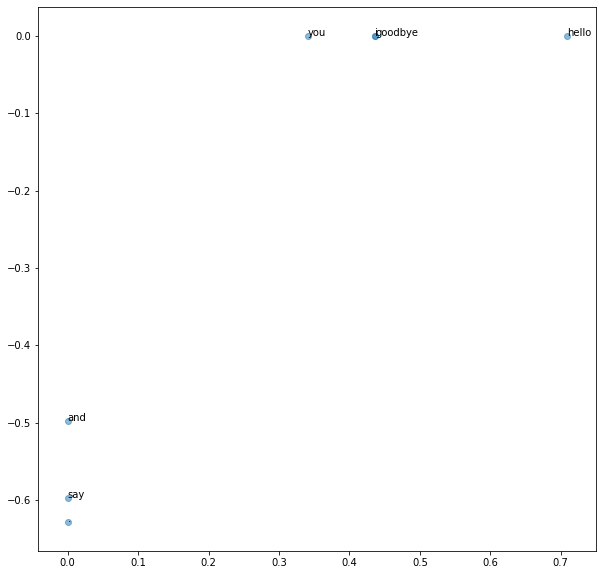

In [51]:
# 각 단어를 2차원 벡터로 표현한 후 그래프로 그리기
plt.figure(figsize=(10,10))
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[: ,0], U[:,1], alpha= 0.5)
plt.show()

### PTB 데이터셋
* 펜 트리뱅크(PTB) : 말뭉치 텍스트 파일로 제공되고, 몇가지 전처리를 한다.

In [58]:
import sys
sys.path.append('..')
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기: ', len(corpus))
print('corpus[:30]:', corpus[:30])
print()

print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()

print("word_to_id['car']: ", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

Done
말뭉치 크기:  929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']:  3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


질문사항

    print('id_to_word[0]:', id_to_word[0])
    print('id_to_word[1]:', id_to_word[1])
    print('id_to_word[2]:', id_to_word[2])
    print()

    print("word_to_id['car']: ", word_to_id['car'])
    print("word_to_id['happy']:", word_to_id['happy'])
    print("word_to_id['lexus']:", word_to_id['lexus'])
    
> 위의 코드에서 id_to_word는 '' 작은 따옴표 가능한데, 아래 word_to_id는 왜 "" 큰 따옴표를 사용하나요?

In [59]:
#PTB 데이터셋 평가
import sys
sys.path.append('..')
import numpy as np
from common.util import most_similar, create_co_matrix, ppmi
from dataset import ptb

window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산 ...')
W = ppmi(C, verbose= True)

print('SVD 계산 ...')
try:
    # truncated SVD가 정말 빠르다고!
    from sklearn.tuils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter = 5, random_state = None)
    
except ImportError:
    #SVD 느리다
    U, S, V = np.linalg.svd(W)
    
word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

동시발생 수 계산 ...
PPMI 계산 ...
1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
100.0% 완료
SVD 계산 ...


/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)



[query] you
 i: 0.700317919254303
 we: 0.6367185115814209
 anybody: 0.565764307975769
 do: 0.563567042350769
 'll: 0.5127798318862915

[query] year
 month: 0.6961644291877747
 quarter: 0.6884941458702087
 earlier: 0.6663320660591125
 last: 0.6281364560127258
 next: 0.6175755858421326

[query] car
 luxury: 0.6728832125663757
 auto: 0.6452109813690186
 vehicle: 0.6097723245620728
 cars: 0.6032834053039551
 corsica: 0.5698372721672058

[query] toyota
 motor: 0.7585658431053162
 nissan: 0.7148030996322632
 motors: 0.6926157474517822
 lexus: 0.6583304405212402
 honda: 0.6350275278091431


Truncated SVD가 특잇값이 큰 것만 계산하고 기본적인 SVD보다 훨씬 빠르다.

## 정리
* WordNet 등 시소러스를 이용하면 유의어를 얻거나 단어 사이의 유사도 측정 등 유용한 작업을 할 수 있다.
* 시소러스 기반 기법은 시소러스를 작성하는 데 엄청난 인적 자원이 든다거나 새로운 단어에 대응하기 어렵다는 문제가 있다.
* 현재는 말뭉치를 이용해 단어를 벡터화하는 방식이 주로 쓰인다.
* 최근의 단어 벡터화 기법들은 대부분 '단어의 의미가 주변 단어에 의해 형성된다'(분포 가설), 이에 기초한다.
* 통계 기반 기법은 말뭉치 안의 각 단어에 대해서 그 단어의 주변 단어의 빈도를 집계한다.(동시발생 행렬)
* 동시발생 행렬을 PPMI 행렬로 변환하고 다시 차원을 감소시킴으로써, 거대한 '희소벡터'를 작은 '밀집벡터'로 변환 가능하다.
* 단어의 벡터 공간에서는 의미가 가까운 단어는 그 거리도 가까울 것으로 기대한다.